<a href="https://colab.research.google.com/github/faisalahm3d/Research/blob/master/Two_Channel_CNN_Structural_Evolutionary_with_attention_Serine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np

In [3]:
def calculate_performance(test_num, pred_y, labels):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for index in range(test_num):
        if labels[index] == 1:
            if labels[index] == pred_y[index]:
                tp = tp + 1
            else:
                fn = fn + 1
        else:
            if labels[index] == pred_y[index]:
                tn = tn + 1
            else:
                fp = fp + 1

    # entering any of the else statement means that the evaluation metric is invalid
    acc = float(tp + tn) / test_num
    
    if((tp + fp) != 0):
      sensitivity = float(tp) / (tp + fn)
    else:
      sensitivity = 0

    if((tn + fp) != 0):
      specificity = float(tn) / (tn + fp)
    else:
      specificity = 0
    
    precision = tp / (tp + fp)

    MCC = float(tp * tn - fp * fn) / (np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))
    
    return acc, sensitivity, specificity, precision, MCC

In [4]:
import numpy as np
npzfile = np.load('/content/drive/MyDrive/DLPhos/normalized_balanced_pssm_spd_profile/train_balanced_S_10.npz', allow_pickle=True)
x_train= npzfile['arr_0']
y_train= npzfile['arr_1']
x_test = npzfile['arr_2']
y_test = npzfile['arr_3']

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=10)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [ ]:
y_test

array([0, 0, 0, ..., 1, 1, 0], dtype=int32)

In [ ]:
from tensorflow.keras.utils import to_categorical as labelEncoding
y_train = labelEncoding(y_train, dtype=int)
y_test  = labelEncoding(y_test, dtype=int)

In [7]:
def get_pssm_spd(data):
  row, col = data.shape
  print (row)
  pssm= data[:, :420]
  spd = data[:, 420:]
  return np.array([pssm[r,:].reshape(21,20) for r in range(row)]), np.array([spd[r, :].reshape(21,8) for r in range(row)])

In [ ]:
x_test.shape

(7306, 588)

In [ ]:
x_train.shape

(55182, 588)

In [8]:
trainX1, trainX2 = get_pssm_spd(x_train)
testX1, testX2 = get_pssm_spd(x_test)
valX1, valtX2 = get_pssm_spd(x_val)

49663
7306
5519


In [ ]:
trainX1.shape

(46904, 21, 20)

In [10]:
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, MaxPooling1D, Flatten,concatenate,GlobalMaxPool1D
from keras import Model
from tensorflow.keras.optimizers import (RMSprop, Adam, SGD)
from keras.models import load_model
from tensorflow.keras.utils import plot_model
from keras import regularizers
from keras.regularizers import (l1, l2, l1_l2)
from keras.callbacks import (EarlyStopping, ModelCheckpoint)
from tensorflow.keras.optimizers import (RMSprop, Adam, SGD)
from keras.layers import (Input, Dense, Dropout, Flatten, BatchNormalization,
                                     Conv1D, Conv2D, MaxPooling1D, MaxPooling2D,
                                     LSTM, GRU, Embedding, Bidirectional, Concatenate)

In [ ]:
def get_structural_model():
    ### Head-1:
    input1 = Input(shape=trainX2[0].shape)

    x = Conv1D(filters=32, kernel_size=3, padding='same', kernel_regularizer=l2(l=0.01))(input1)
    #x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    #x = Conv1D(filters=8, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(x)
    #x = BatchNormalization()(x)
    #x = Dropout(rate=0.50)(x)

    head1 = Flatten()(x)

    z= Dense(units=256, activation='relu',)(head1)
    z = Dropout(rate=0.5)(z)

    z = Dense(units=64, activation='relu',)(z)
    z = Dropout(rate=0.5)(z)

    z = Dense(units=16, activation='relu',)(z)
    z = Dropout(rate=0.5)(z)
    
    z = Dense(1, activation='sigmoid')(z)

    return Model(inputs=[input1], outputs=[z])
#end-def

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21, 8)]           0         
                                                                 
 conv1d (Conv1D)             (None, 21, 32)            800       
                                                                 
 dropout (Dropout)           (None, 21, 32)            0         
                                                                 
 flatten (Flatten)           (None, 672)               0         
                                                                 
 dense (Dense)               (None, 256)               172288    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448 

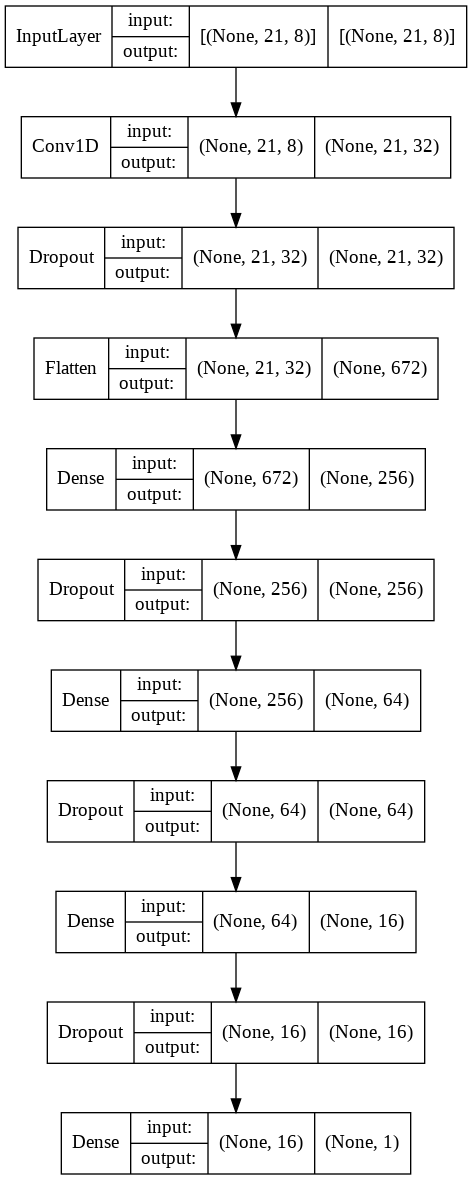

In [ ]:
model = get_structural_model()
model.summary()
plot_model(model, to_file='model-spd.png', show_shapes=True, show_layer_names=False, expand_nested=True)

In [ ]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# save the best model
mc = ModelCheckpoint('best_model_spd.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
# Compile Model:
#model = Ne()
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Run Model:
history = model.fit(x=trainX2, y= y_train, validation_data=(testX2, y_test), batch_size=32, epochs=200, verbose=1, callbacks=[es,mc])

Epoch 1/200
1663/1669 [============================>.] - ETA: 0s - loss: 0.7428 - accuracy: 0.5876
Epoch 1: val_accuracy improved from -inf to 0.68307, saving model to best_model_spd.h5
1669/1669 [==============================] - 10s 6ms/step - loss: 0.7425 - accuracy: 0.5876 - val_loss: 0.6583 - val_accuracy: 0.6831
Epoch 2/200
1664/1669 [============================>.] - ETA: 0s - loss: 0.6451 - accuracy: 0.6449
Epoch 2: val_accuracy improved from 0.68307 to 0.69825, saving model to best_model_spd.h5
1669/1669 [==============================] - 9s 5ms/step - loss: 0.6451 - accuracy: 0.6450 - val_loss: 0.6039 - val_accuracy: 0.6982
Epoch 3/200
1667/1669 [============================>.] - ETA: 0s - loss: 0.6054 - accuracy: 0.6855
Epoch 3: val_accuracy improved from 0.69825 to 0.72606, saving model to best_model_spd.h5
1669/1669 [==============================] - 9s 5ms/step - loss: 0.6053 - accuracy: 0.6856 - val_loss: 0.5570 - val_accuracy: 0.7261
Epoch 4/200
1668/1669 [=============

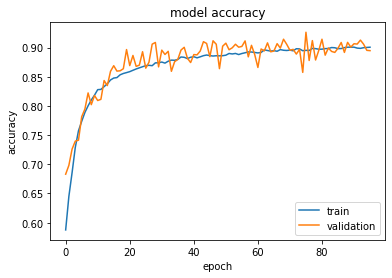

In [ ]:
from matplotlib import pyplot as plt
#plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='lower right')
plt.savefig('accuracy_curve_spd_balanced_smote.png')
plt.show()

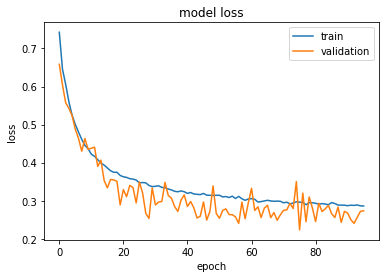

In [ ]:
#plot training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot()
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.savefig('loss_curve_spd_balanced_smote.png')
plt.show()

In [ ]:
# load the saved model
saved_model = load_model('best_model_spd.h5')
# evaluate the model
#_, train_acc = saved_model.evaluate(trainX, trainy, verbose=0)
#_, test_acc = saved_model.evaluate(testX, testy, verbose=0)
#print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

In [ ]:
probabilities = saved_model.predict(testX2)
predicted_classes = probabilities >= 0.5
predicted_classes = predicted_classes.astype(int)
acc, sensitivity, specificity, precision, MCC = calculate_performance(len(y_test),predicted_classes , y_test)

print('Result Summary:')
print('------------------------------')
print('accuracy: ',acc, end =", ")
print('sensitivity: ',sensitivity, end =", ")
print('specificity: ',specificity, end =" ,")
print('precision: ',precision, end =" ,")
print('MCC : ',MCC)

Result Summary:
------------------------------
accuracy:  0.9263317599460553, sensitivity:  0.9779808890735355, specificity:  0.8910638297872341 ,precision:  0.8597516435354273 ,MCC :  0.8560035242805009


In [ ]:
def get_evolutionary_model():
    ### Head-1:
    input1 = Input(shape=trainX1[0].shape)

    x = Conv1D(filters=32, kernel_size=3, padding='same', kernel_regularizer=l2(l=0.01))(input1)
    #x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    #x = Conv1D(filters=8, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(x)
    #x = BatchNormalization()(x)
    #x = Dropout(rate=0.50)(x)

    head1 = Flatten()(x)

    z= Dense(units=256, activation='relu',)(head1)
    z = Dropout(rate=0.5)(z)

    z = Dense(units=64, activation='relu',)(z)
    z = Dropout(rate=0.5)(z)

    z = Dense(units=16, activation='relu',)(z)
    z = Dropout(rate=0.5)(z)
    
    z = Dense(1, activation='sigmoid')(z)

    return Model(inputs=[input1], outputs=[z])
#end-def

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 21, 20)]          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 21, 32)            1952      
                                                                 
 dropout_4 (Dropout)         (None, 21, 32)            0         
                                                                 
 flatten_1 (Flatten)         (None, 672)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               172288    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                1644

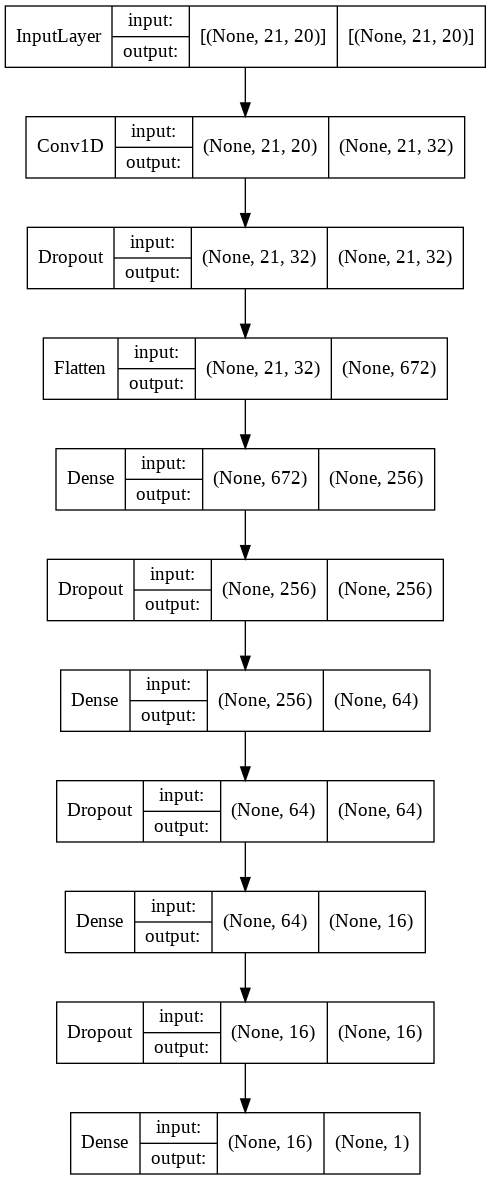

In [ ]:
model = get_evolutionary_model()
model.summary()
plot_model(model, to_file='model-pssm.png', show_shapes=True, show_layer_names=False, expand_nested=True)

In [ ]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# save the best model
mc = ModelCheckpoint('best_model_pssm.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# Compile Model:
#model = Ne()
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Run Model:
history = model.fit(x=trainX1, y= y_train, validation_data=(testX1, y_test), batch_size=32, epochs=200, verbose=1, callbacks=[es,mc])

Epoch 1/200
1667/1669 [============================>.] - ETA: 0s - loss: 0.6864 - accuracy: 0.6340
Epoch 1: val_accuracy improved from -inf to 0.66976, saving model to best_model_pssm.h5
1669/1669 [==============================] - 10s 6ms/step - loss: 0.6863 - accuracy: 0.6341 - val_loss: 0.6238 - val_accuracy: 0.6698
Epoch 2/200
1663/1669 [============================>.] - ETA: 0s - loss: 0.5619 - accuracy: 0.7353
Epoch 2: val_accuracy improved from 0.66976 to 0.73517, saving model to best_model_pssm.h5
1669/1669 [==============================] - 9s 6ms/step - loss: 0.5616 - accuracy: 0.7356 - val_loss: 0.5432 - val_accuracy: 0.7352
Epoch 3/200
1665/1669 [============================>.] - ETA: 0s - loss: 0.4866 - accuracy: 0.7913
Epoch 3: val_accuracy did not improve from 0.73517
1669/1669 [==============================] - 11s 7ms/step - loss: 0.4863 - accuracy: 0.7915 - val_loss: 0.6430 - val_accuracy: 0.6962
Epoch 4/200
1662/1669 [============================>.] - ETA: 0s - loss:

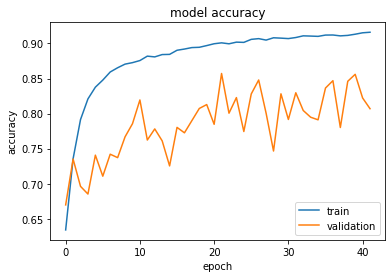

In [ ]:
from matplotlib import pyplot as plt
#plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='lower right')
plt.savefig('accuracy_curve_pssm_balanced_smote.png')
plt.show()

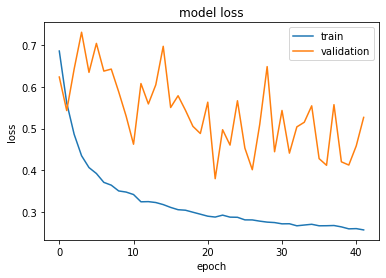

In [ ]:
#plot training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot()
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.savefig('loss_curve_pssm_balanced_smote.png')
plt.show()

In [ ]:
saved_model = load_model('best_model_pssm.h5')
probabilities = saved_model.predict(testX1)
predicted_classes = probabilities >= 0.5
predicted_classes = predicted_classes.astype(int)
acc, sensitivity, specificity, precision, MCC = calculate_performance(len(y_test),predicted_classes , y_test)

print('Result Summary:')
print('------------------------------')
print('accuracy: ',acc, end =", ")
print('sensitivity: ',sensitivity, end =", ")
print('specificity: ',specificity, end =" ,")
print('precision: ',precision, end =" ,")
print('MCC : ',MCC)

Result Summary:
------------------------------
accuracy:  0.8572151045178692, sensitivity:  0.9825508932280848, specificity:  0.7716312056737589 ,precision:  0.7460567823343849 ,MCC :  0.7424246064772515


In [ ]:
!pip install rotation-forest
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier,GradientBoostingClassifier
from rotation_forest import RotationForestClassifier
#ml_model = RandomForestClassifier(n_estimators=100, bootstrap=False, random_state=47, verbose=1)
ml_model = RotationForestClassifier(n_estimators=100, random_state=47, verbose=4, n_jobs=-2)
ml_model.fit(x_train[:, 420: ],y_train )
y_predict = ml_model.predict(x_test[:,420:])

  Created wheel for rotation-forest: filename=rotation_forest-1.0-py3-none-any.whl size=7002 sha256=0cd469f237899cb321ef9c5875d9f851cd83ac839726786caf08e71e9f010a63
  Stored in directory: /root/.cache/pip/wheels/1a/d7/d5/e657bdbc7feafd9f8808611ad808bcffbcb50c71dd93b9e8e4
Successfully built rotation-forest


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   28.1s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=-2)]: Done   2 out of   2 | elapsed:   56.5s remaining:    0.0s


building tree 3 of 100


[Parallel(n_jobs=-2)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s


building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 10

[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed: 47.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.5s finished


In [ ]:
y_predict

array([1, 1, 0, ..., 1, 1, 1], dtype=int32)

In [ ]:
model.save("model_pssm_conv1_train_balanced.h5")

In [ ]:
from tensorflow.keras.layers import Layer, InputSpec
def squeeze_excite_block(self, x):
	# store the input
	shortcut = x
	# calculate the number of filters the input has
	filters = x.shape[-1]
	# the squeeze operation reduces the input dimensionality
	# here we do a global average pooling across the filters, which
	# reduces the input to a 1D vector
	x = GlobalAveragePooling2D(keepdims=True)(x)
	# reduce the number of filters (1 x 1 x C/r)
	x = Dense(filters // self.ratio, activation="relu",
		kernel_initializer="he_normal", use_bias=False)(x)
	
	# the excitation operation restores the input dimensionality
	x = Dense(filters, activation="sigmoid",
		kernel_initializer="he_normal", use_bias=False)(x)
	
	# multiply the attention weights with the original input
	x = Multiply()([shortcut, x])
	# return the output of the SE block
	return x

In [11]:
from tensorflow.keras.layers import Layer, InputSpec
class Position_Embedding(Layer):

    def __init__(self, size=None, mode='concat', **kwargs):

        self.size = size

        self.mode = mode

        super(Position_Embedding, self).__init__(**kwargs)

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.size,
            "arg2": self.mode,
        })
        return config

    def call(self, x):

        if (self.size == None) or (self.mode == 'concat'):
            self.size = int(x.shape[-1])

        position_j = 1. / K.pow(10000., 2 * K.arange(self.size / 2, dtype='float32') / self.size)

        position_j = K.expand_dims(position_j, 0)

        position_i = K.cumsum(K.ones_like(x[:, :, 0]), 1) - 1

        position_i = K.expand_dims(position_i, 2)

        position_ij = K.dot(position_i, position_j)

        position_ij = K.concatenate([K.cos(position_ij), K.sin(position_ij)], 2)

        if self.mode == 'sum':

            return position_ij + x

        elif self.mode == 'concat':

            return K.concatenate([position_ij, x], 2)

    def compute_output_shape(self, input_shape):

        if self.mode == 'sum':

            return input_shape

        elif self.mode == 'concat':

            return (input_shape[0], input_shape[1], input_shape[2] + self.size)


class Self_Attention(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Self_Attention, self).__init__(**kwargs)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.output_dim,
        })
        return config

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(3, input_shape[2], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)

        super(Self_Attention, self).build(input_shape)

    def call(self, x):
        WQ = K.dot(x, self.kernel[0])
        WK = K.dot(x, self.kernel[1])
        WV = K.dot(x, self.kernel[2])
        QK = K.batch_dot(WQ, K.permute_dimensions(WK, [0, 2, 1]))
        QK = QK / (self.output_dim ** 0.5)
        QK = K.softmax(QK)
        V = K.batch_dot(QK, WV)
        return V

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.output_dim)

In [35]:
self_number = 128
weight_decay=0.0001
def get_combined_model():
    ### Head-1:
    input1 = Input(shape=trainX1[0].shape)

    x = Conv1D(filters=64, kernel_size=5, padding='same', kernel_regularizer=l2(l=0.01))(input1)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.50)(x)
    x = Position_Embedding()(x)
    x = Self_Attention(self_number)(x)

    x = Activation('relu')(x)

    x = Dropout(rate = 0.5)(x)

    #x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(x)
    #x = BatchNormalization()(x)
    #x = Dropout(rate=0.50)(x)

    head1 = Flatten()(x)

    #output = Dense(units=128, activation='relu',)(head1)
    #output = BatchNormalization()(output)
    #output = Dropout(rate=0.5)(output)

    #output = Dense(units=64, activation='relu',)(head1)
    #output = BatchNormalization()(output)
    #output = Dropout(rate=0.5)(output)


    #output = Dense(units=32, activation='relu',)(output)
    #output = BatchNormalization()(output)
    #output = Dropout(rate=0.5)(output)
    
    #output = Dense(units=8, activation='relu',)(output)
    #output = BatchNormalization()(output)
    #output = Dropout(rate=0.25)(output)

    x = Model(inputs=[input1], outputs=[head1])


        ### Head-1:
    input2 = Input(shape=trainX2[0].shape)

    y = Conv1D(filters=64, kernel_size=5, padding='same', kernel_regularizer=l2(l=0.01))(input2)
    y = BatchNormalization()(y)
    y = Dropout(rate=0.5)(y)
    y = Position_Embedding()(y)
    y = Self_Attention(self_number)(y)

    y = Activation('relu')(y)

    y = Dropout(rate = 0.5)(y)

    #y = Conv1D(filters=16, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(y)
    #y = BatchNormalization()(y)
    #y = Dropout(rate=0.50)(y)

    head2 = Flatten()(y)
    #output2 = Dense(units=128, activation='relu',)(head2)
    #output2 = BatchNormalization()(output2)
    #output2 = Dropout(rate=0.5)(output2)

    #output2 = Dense(units=64, activation='relu',)(head2)
    #output2 = BatchNormalization()(output2)
    #output2 = Dropout(rate=0.5)(output2)


    #output2 = Dense(units=32, activation='relu',)(output2)
    #output2 = BatchNormalization()(output2)
    #output2 = Dropout(rate=0.5)(output2)
    
    #output2 = Dense(units=8, activation='relu',)(output2)
    #output2 = BatchNormalization()(output2)
    #output2 = Dropout(rate=0.5)(output2)


    y = Model(inputs=[input2], outputs=[head2])

    combined = concatenate([x.output, y.output])

    z= Dense(units=2048, activation='relu', kernel_regularizer=l2(weight_decay),
              bias_regularizer=l2(weight_decay))(combined)
    #output2 = BatchNormalization()(output2)
    z = Dropout(rate=0.5)(z)

    z= Dense(units=1024, activation='relu',kernel_regularizer=l2(weight_decay),
              bias_regularizer=l2(weight_decay))(combined)
    #output2 = BatchNormalization()(output2)
    z = Dropout(rate=0.5)(z)

    z= Dense(units=512, activation='relu',kernel_regularizer=l2(weight_decay),
              bias_regularizer=l2(weight_decay))(combined)
    #output2 = BatchNormalization()(output2)
    z = Dropout(rate=0.5)(z)

    z= Dense(units=256, activation='relu',kernel_regularizer=l2(weight_decay),
              bias_regularizer=l2(weight_decay))(z)
    #output2 = BatchNormalization()(output2)
    z = Dropout(rate=0.5)(z)

    
    z= Dense(units=128, activation='relu',kernel_regularizer=l2(weight_decay),
              bias_regularizer=l2(weight_decay))(z)
    #output2 = BatchNormalization()(output2)
    z = Dropout(rate=0.5)(z)

    z = Dense(units=64, activation='relu',kernel_regularizer=l2(weight_decay),
              bias_regularizer=l2(weight_decay))(z)
    #output2 = BatchNormalization()(output2)
    z = Dropout(rate=0.5)(z)


    z = Dense(units=32, activation='relu',kernel_regularizer=l2(weight_decay),
              bias_regularizer=l2(weight_decay))(z)
    #output2 = BatchNormalization()(output2)
    z = Dropout(rate=0.5)(z)
    
    z = Dense(units=16, activation='relu',kernel_regularizer=l2(weight_decay),
              bias_regularizer=l2(weight_decay))(z)
    #output2 = BatchNormalization()(output2)
    z = Dropout(rate=0.5)(z)
    #z = Dense(8, activation='relu')(z)
    #z = BatchNormalization()(z)
    #z = Dropout(rate=0.5)(z)
    z = Dense(1, activation='sigmoid')(z)
    
    # our model will accept the inputs of the two branches and
    # then output a single value
    return Model(inputs=[x.input, y.input], outputs=z)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 21, 20)]     0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 21, 8)]      0           []                               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 21, 64)       6464        ['input_5[0][0]']                
                                                                                                  
 conv1d_5 (Conv1D)              (None, 21, 64)       2624        ['input_6[0][0]']                
                                                                                            

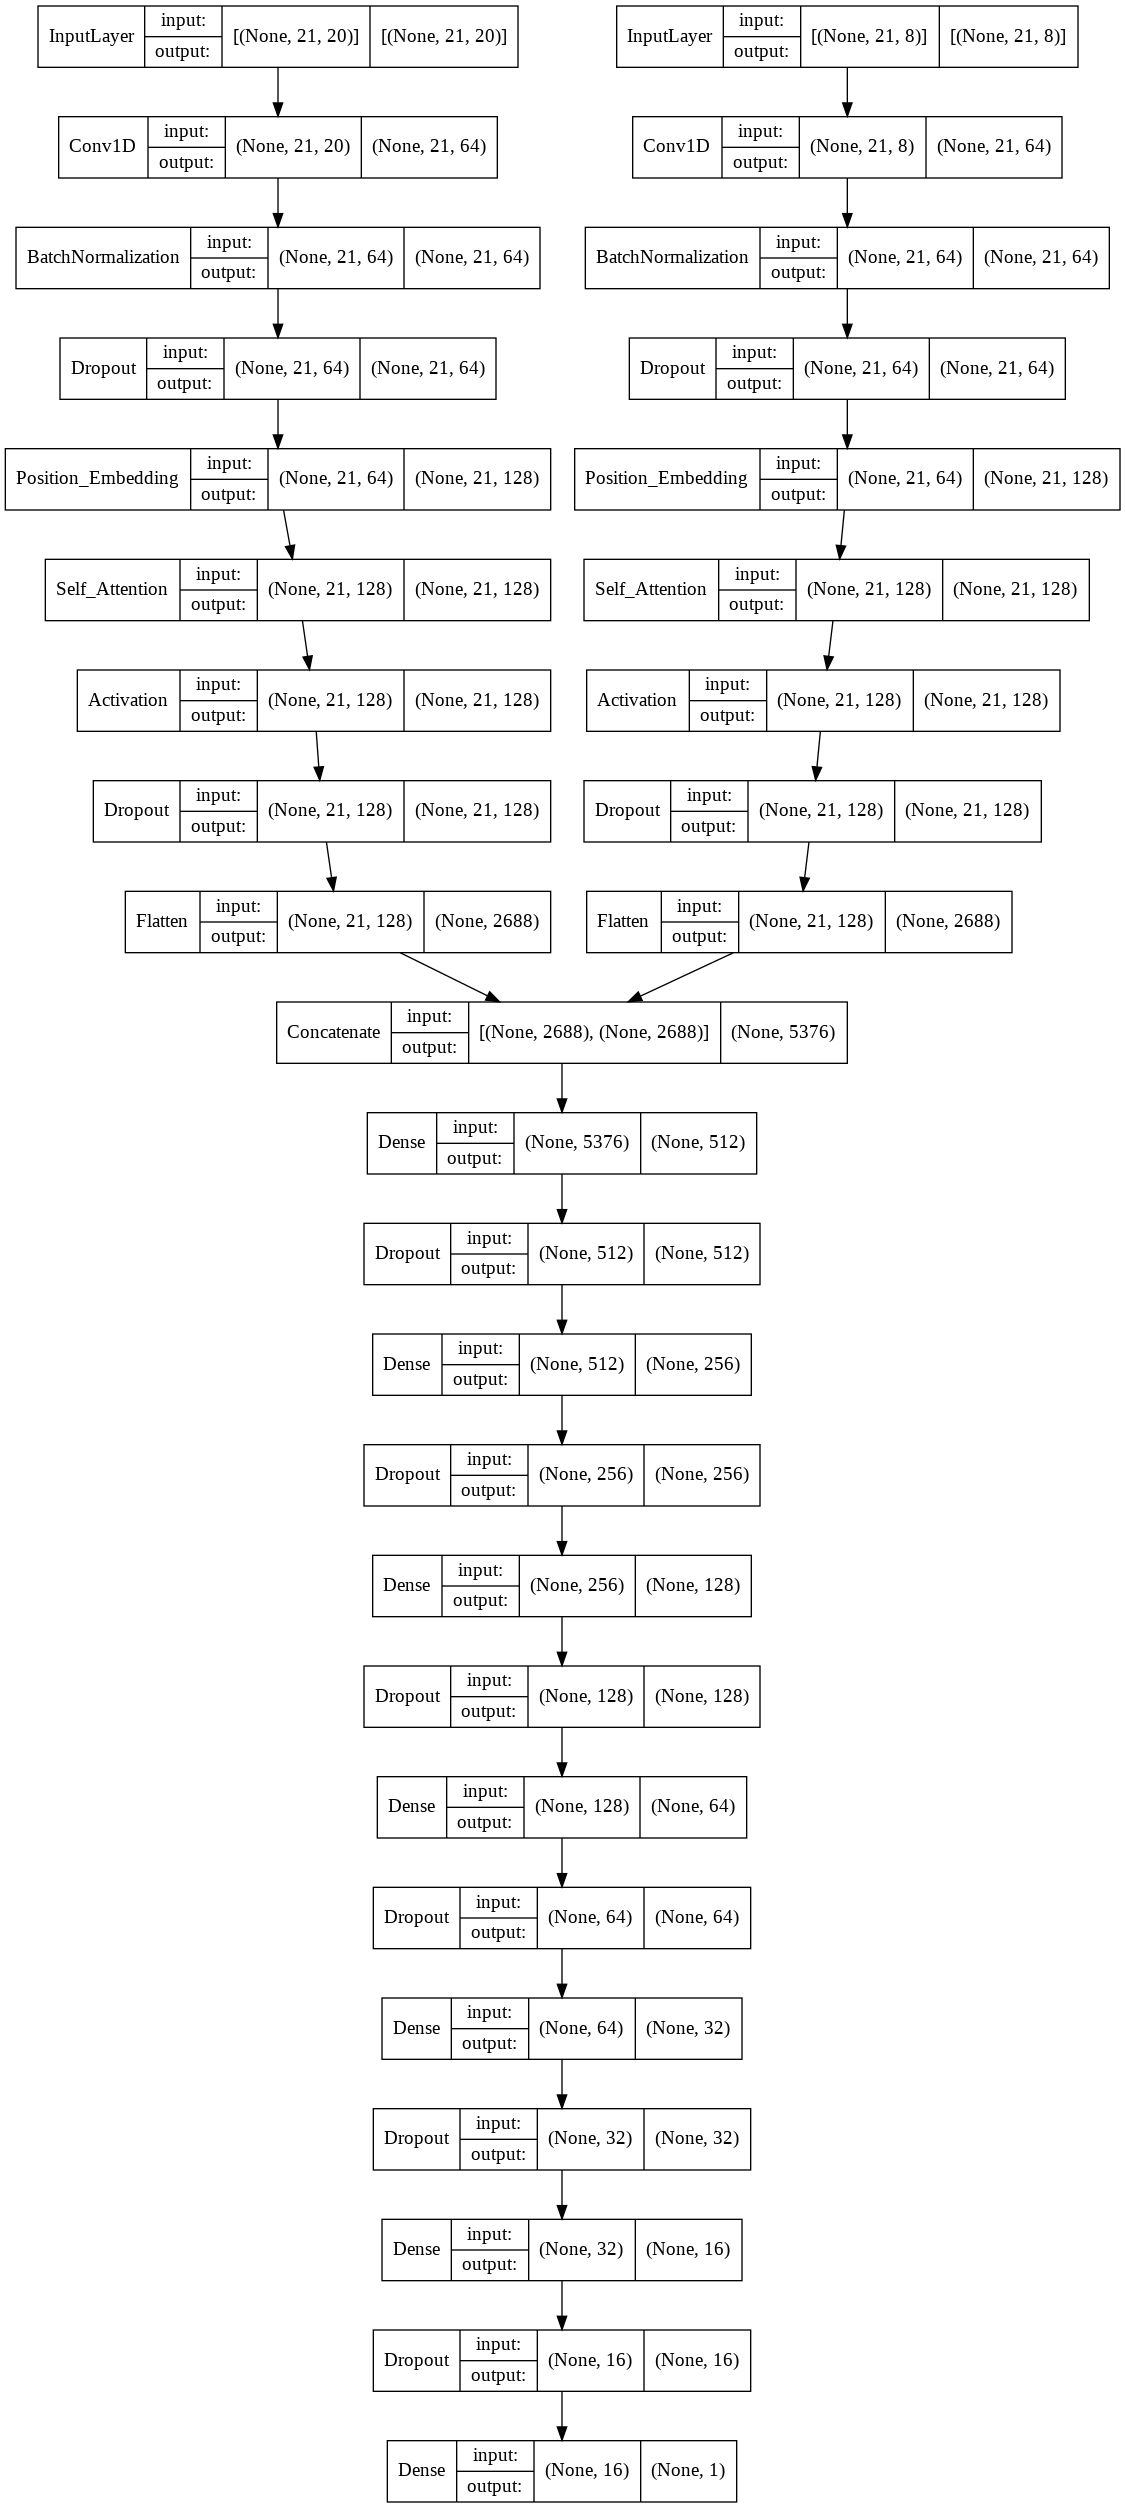

In [36]:
import tensorflow.keras.backend as K
model = get_combined_model()
model.summary()
plot_model(model, to_file='model-combined.png', show_shapes=True, show_layer_names=False, expand_nested=True)

In [37]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# save the best model
mc = ModelCheckpoint('best_model_combined.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [38]:
# Compile Model:
from tensorflow.keras.optimizers import (RMSprop, Adam, SGD)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy',metrics=['accuracy'])

# Run Model:
#history = model.fit(x=trainX1, y= y_train, validation_data=(testX1, y_test), batch_size=16, epochs=100, verbose=1, callbacks=[])
history=model.fit(x=[trainX1, trainX2], y=y_train, validation_data=([valX1, valtX2], y_val), epochs=100, batch_size=32, callbacks=[es,mc], verbose = 1)

Epoch 1/100
1550/1552 [============================>.] - ETA: 0s - loss: 0.8357 - accuracy: 0.6249
Epoch 1: val_accuracy improved from -inf to 0.71317, saving model to best_model_combined.h5
1552/1552 [==============================] - 16s 9ms/step - loss: 0.8357 - accuracy: 0.6249 - val_loss: 0.7216 - val_accuracy: 0.7132
Epoch 2/100
1551/1552 [============================>.] - ETA: 0s - loss: 0.6902 - accuracy: 0.7245
Epoch 2: val_accuracy did not improve from 0.71317
1552/1552 [==============================] - 12s 8ms/step - loss: 0.6902 - accuracy: 0.7245 - val_loss: 0.7179 - val_accuracy: 0.6849
Epoch 3/100
1551/1552 [============================>.] - ETA: 0s - loss: 0.6419 - accuracy: 0.7498
Epoch 3: val_accuracy improved from 0.71317 to 0.72767, saving model to best_model_combined.h5
1552/1552 [==============================] - 14s 9ms/step - loss: 0.6418 - accuracy: 0.7498 - val_loss: 0.6831 - val_accuracy: 0.7277
Epoch 4/100
1550/1552 [============================>.] - ETA: 0

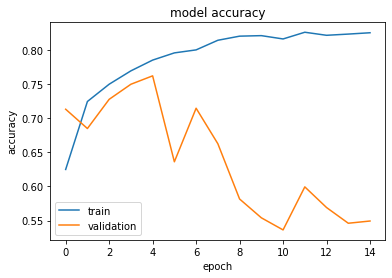

In [39]:
from matplotlib import pyplot as plt
#plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='lower left')
plt.savefig('accuracy_curve_combined.png')
plt.show()

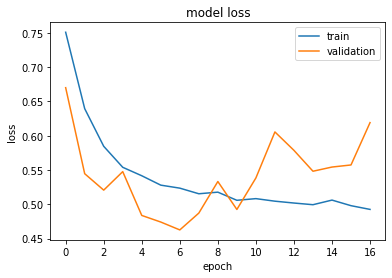

In [30]:
#plot training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot()
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.savefig('loss_curve_combined.png')
plt.show()

In [31]:
probabilities = model.predict([testX1,testX2])
predicted_classes = probabilities >= 0.5
predicted_classes = predicted_classes.astype(int)

In [32]:
res = model.evaluate([testX1,testX2], y_test)

229/229 [==============================] - 1s 4ms/step - loss: 1.1209 - accuracy: 0.3430


In [ ]:
res

[0.5982548594474792, 0.8894059658050537]

In [33]:
acc,  sensitivity, specificity, precision, MCC = calculate_performance(len(y_test), predicted_classes, y_test)
print('Result Summary:')
print('------------------------------')
print('accuracy',acc, end =", ")
print('MCC',MCC, end =", ")
print('sensitivity',sensitivity, end =",")
print('precision',precision, end =",")
print('specificity',specificity)

Result Summary:
------------------------------
accuracy 0.34300574869969885, MCC 0.06992976420796893, sensitivity 0.8259803921568627,precision 0.06652191077773391,specificity 0.3144389678167585


In [34]:
from tensorflow.keras.models import load_model
model = load_model('/content/best_model_combined.h5')
probabilities = model.predict([valX1,valtX2])
predicted_classes = probabilities >= 0.5
predicted_classes = predicted_classes.astype(int)
res = model.evaluate([testX1,testX2], y_test)

ValueError: ignored

In [ ]:
acc,  sensitivity, specificity, precision, MCC = calculate_performance(len(y_val), predicted_classes, y_val)
print('Result Summary:')
print('------------------------------')
print('accuracy',acc, end =", ")
print('MCC',MCC, end =", ")
print('sensitivity',sensitivity, end =",")
print('precision',precision, end =",")
print('specificity',specificity)

Result Summary:
------------------------------
accuracy 0.9780757383583982, MCC 0.9569411737911745, sensitivity 0.9989308624376336,precision 0.9596028757274906,specificity 0.9565057132325838


In [22]:
# Outputs of the 8 layers, which include conv2D and max pooling layers
layer_outputs = model.layers[13]
activation_model = Model(inputs = model.input, outputs = layer_outputs.output)
activations = activation_model.predict([valX1, valtX2])

In [23]:
activations[0].shape

(2688,)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


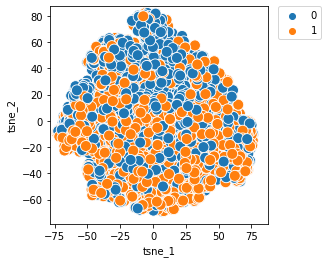

In [24]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
 
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(activations)
tsne_result.shape
# (1000, 2)
# Two dimensions for each of our images
 
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y_val})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)